## Comparison of different learning rates in planning with TD(0)
Sumana Basu (260727568) & Charles C Onu (260663256)

**Problem Description :**

In the context of wall following domain, we intend to solve the prediction problem of estimating value function $v_\pi$ for the a given policy $\pi$

**Domain : **

In the wall following domain -
* Robot starts from one of the bottom three states (as in fig.) and
* Works its way up one row at a time
* Trial terminates if -
    * robot runs into the wall
    * wanders off into the "open space"
    * successfully reaches the exit

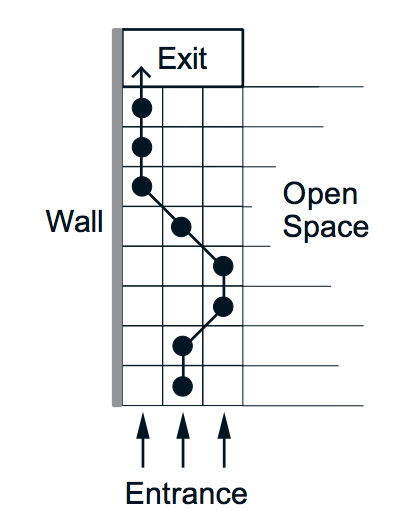

In [1]:
from IPython.display import Image
Image(filename='Sample Trajectory.png')

**Policy : **

The robot's wall-following policy tries to keep the robot in the center column, neither too close to the wall, which risks a collision, nor too far from it.

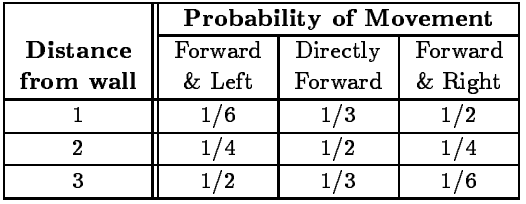

In [2]:
Image(filename='policy.png')

**Goal : **

To reach the exit

**Reward structure: **
* If the robot hits the wall or wanders off into the "open space" : 0
* If the robot reaches the exit : +1
* Everywhere else : -1

** Solution : **

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Parameters for calculating the actual state value estimates :

In [4]:
#Learning Rate
ALPHA = 0.01

#Discount Factor
GAMMA = 0.9

#Number of Episodes
NUM_EPISODES = 50000

Evaluation parameters :

In [5]:
#Number of episodes
n_episodes = 4000

#Number of look-ahead steps. This is 1 for TD(0)
n_runs = 1

#Different learning parameters
alphas = [0.01, 0.05, 0.1, 0.5, 0.9]

**Defining Environment**

In [6]:
#Define States
states = ['00', '01', '02',
          '03', '04', '05',
          '06', '07', '08',
          '09', '10', '11',
          '12', '13', '14',
          '15', '16', '17',
          '18', '19', '20',
          '21', '22', '23',
          '24', '25', '26',]

In [7]:
EXIT_STATES = ['24','25','26']

In [8]:
intermediate_states = [s for s in states if s not in EXIT_STATES]

In [9]:
#Define Actions
actions = ['FORWARD_LEFT', 'DIRECTLY_FORWARD', 'FORWARD_RIGHT']

FORWARD_LEFT = 'FORWARD_LEFT'
DIRECTLY_FORWARD = 'DIRECTLY_FORWARD'
FORWARD_RIGHT = 'FORWARD_RIGHT'

In [10]:
#Define state transitions
state_transitions = {
                '00' : {FORWARD_LEFT:'00', DIRECTLY_FORWARD : '03', FORWARD_RIGHT : '04'},
                '01' : {FORWARD_LEFT:'03', DIRECTLY_FORWARD : '04', FORWARD_RIGHT : '05'},
                '02' : {FORWARD_LEFT:'04', DIRECTLY_FORWARD : '05', FORWARD_RIGHT : '02'},
                '03' : {FORWARD_LEFT:'03', DIRECTLY_FORWARD : '06', FORWARD_RIGHT : '07'},   
                '04' : {FORWARD_LEFT:'06', DIRECTLY_FORWARD : '07', FORWARD_RIGHT : '08'}, 
                '05' : {FORWARD_LEFT:'07', DIRECTLY_FORWARD : '08', FORWARD_RIGHT : '05'},
                '06' : {FORWARD_LEFT:'06', DIRECTLY_FORWARD : '09', FORWARD_RIGHT : '10'},   
                '07' : {FORWARD_LEFT:'09', DIRECTLY_FORWARD : '10', FORWARD_RIGHT : '11'},    
                '08' : {FORWARD_LEFT:'10', DIRECTLY_FORWARD : '11', FORWARD_RIGHT : '08'},
                '09' : {FORWARD_LEFT:'09', DIRECTLY_FORWARD : '12', FORWARD_RIGHT : '13'},
                '10' : {FORWARD_LEFT:'12', DIRECTLY_FORWARD : '13', FORWARD_RIGHT : '14'},
                '11' : {FORWARD_LEFT:'13', DIRECTLY_FORWARD : '14', FORWARD_RIGHT : '11'},
                '12' : {FORWARD_LEFT:'12', DIRECTLY_FORWARD : '15', FORWARD_RIGHT : '16'},
                '13' : {FORWARD_LEFT:'15', DIRECTLY_FORWARD : '16', FORWARD_RIGHT : '17'},
                '14' : {FORWARD_LEFT:'16', DIRECTLY_FORWARD : '17', FORWARD_RIGHT : '14'},
                '15' : {FORWARD_LEFT:'15', DIRECTLY_FORWARD : '18', FORWARD_RIGHT : '19'},
                '16' : {FORWARD_LEFT:'18', DIRECTLY_FORWARD : '19', FORWARD_RIGHT : '20'},
                '17' : {FORWARD_LEFT:'19', DIRECTLY_FORWARD : '20', FORWARD_RIGHT : '17'},
                '18' : {FORWARD_LEFT:'18', DIRECTLY_FORWARD : '21', FORWARD_RIGHT : '22'},
                '19' : {FORWARD_LEFT:'21', DIRECTLY_FORWARD : '22', FORWARD_RIGHT : '23'},
                '20' : {FORWARD_LEFT:'22', DIRECTLY_FORWARD : '23', FORWARD_RIGHT : '20'},
                '21' : {FORWARD_LEFT:'21', DIRECTLY_FORWARD : '24', FORWARD_RIGHT : '25'},
                '22' : {FORWARD_LEFT:'24', DIRECTLY_FORWARD : '25', FORWARD_RIGHT : '26'},
                '23' : {FORWARD_LEFT:'25', DIRECTLY_FORWARD : '26', FORWARD_RIGHT : '23'},
                '24' : {FORWARD_LEFT:'24', DIRECTLY_FORWARD : '24', FORWARD_RIGHT : '24'},
                '25' : {FORWARD_LEFT:'25', DIRECTLY_FORWARD : '25', FORWARD_RIGHT : '25'},
                '26' : {FORWARD_LEFT:'26', DIRECTLY_FORWARD : '26', FORWARD_RIGHT : '26'}
              }

Sampling action based on policy $\pi$ :

In [11]:
def generateRandomAction(distance_from_wall):
    random_prob = random.uniform(0,1)
    #print random_prob
    if distance_from_wall == 1:
        if random_prob >= 1.0/2:
            return 'FORWARD_RIGHT'
        elif random_prob >= 1.0/3:
            return 'DIRECTLY_FORWARD'
        else:
            return 'FORWARD_LEFT'
    elif distance_from_wall == 2:
        if random_prob >= 1.0/2:
            return 'DIRECTLY_FORWARD'
        else:
            r = random.randint(0,1)
            if r == 0:
                return 'FORWARD_LEFT'
            else:
                return 'FORWARD_RIGHT'
    else:
        if random_prob >= 1.0/2:
            return 'FORWARD_LEFT'
        elif random_prob >= 1.0/3:
            return 'DIRECTLY_FORWARD'
        else:
            return 'FORWARD_RIGHT'

In [12]:
def getNextState(currentState, action):
    nextState = state_transitions[currentState][action]
    if currentState == nextState:
        reward = 0
    elif nextState in EXIT_STATES:
        reward = 1
    else:
        reward = -1
    return nextState, reward

Generating episodes :

In [13]:
def generateEpisode():
    step_state = []
    step_action = []
    step_reward = []

    #All 3 starting states are equally likely
    r = random.randint(0,2)
    if r == 0:
        start_state = '00'
    elif r == 1:
        start_state = '01'
    else:
        start_state = '02'

    curr_state = start_state

    while curr_state not in EXIT_STATES:

        distance_from_wall = int(curr_state) % 3 + 1
        action = generateRandomAction(distance_from_wall)
        next_state, reward = getNextState(curr_state, action)

        step_state.append(curr_state)
        step_action.append(action)
        step_reward.append(reward)

        curr_state = next_state
        if reward == 0:
            break
    
    return step_state, step_action, step_reward

In [14]:
#Generate Episodes

all_episodes_state = []
all_episodes_action = []
all_episodes_reward = []

for i in range(NUM_EPISODES):
    s, a, r = generateEpisode()

    all_episodes_state.append(s)
    all_episodes_action.append(a)
    all_episodes_reward.append(r)

In [15]:
#Define initial state values under given policy

state_value = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)

**TD(0)**

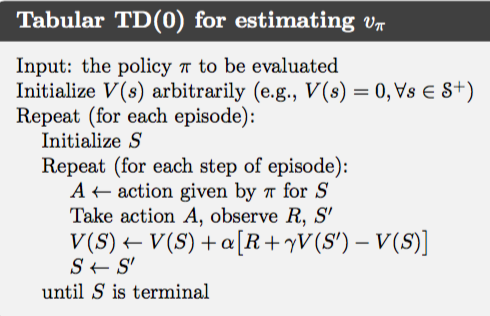

In [16]:
Image(filename='TD0 Algorithm.png')

In [17]:
def TD0():
    #start_state = '00'
    for i in range(NUM_EPISODES):
        for state, action, reward in zip(all_episodes_state[i], all_episodes_action[i], all_episodes_reward[i]):
            expected_return = reward + GAMMA * state_value[state_transitions[state][action]]
            state_value[state] = state_value[state] + ALPHA * (expected_return - state_value[state])
            #print state, action, reward
    #print(state_value)

In [18]:
TD0()
#state_value
actual_state_value = state_value

In [19]:
actual_state_value

{'00': -4.3189926078524605,
 '01': -4.52214322364649,
 '02': -4.317739340744631,
 '03': -3.836380339944763,
 '04': -3.9986930438062496,
 '05': -3.810536875060844,
 '06': -3.300610674827489,
 '07': -3.3950406817042555,
 '08': -3.2568177849420414,
 '09': -2.6316348697440493,
 '10': -2.7377505481400277,
 '11': -2.5751220371813988,
 '12': -1.897493679408096,
 '13': -1.9705656146300916,
 '14': -1.8984791092230158,
 '15': -1.051651738834133,
 '16': -1.1022838013425245,
 '17': -1.0579879101600311,
 '18': -0.10710588865005526,
 '19': -0.12193764453014412,
 '20': -0.1062629337702898,
 '21': 0.9458679682921775,
 '22': 0.9999999999999944,
 '23': 0.9480801884564887,
 '24': 0,
 '25': 0,
 '26': 0}

**Evaluation**

In [20]:
def rmse(state_value, actual_state_value):
    sq_error_sum = 0
    for cur_state in states:
        sq_error = (state_value[cur_state] - actual_state_value[cur_state]) ** 2
        sq_error_sum += sq_error
    avg_sq_error = sq_error_sum / len(state_value)
    return avg_sq_error

In [21]:
def TD0_evaluate(n_episodes, n_runs, alpha):
    #start_state = '00'
    
    rmse_all_runs = np.zeros((n_episodes, n_runs))
    
    for k in range(n_runs):
        rmse_per_episode = np.zeros(n_episodes)
        for i in range(n_episodes):
            
            for state, action, reward in zip(all_episodes_state[i], all_episodes_action[i], all_episodes_reward[i]):                
                expected_return = reward + GAMMA * state_value[state_transitions[state][action]]
                state_value[state] = state_value[state] + alpha * (expected_return - state_value[state])

            rmse_per_episode[i] = rmse(state_value, actual_state_value)
        rmse_all_runs[:,k] = rmse_per_episode  
        
    return state_value, rmse_all_runs

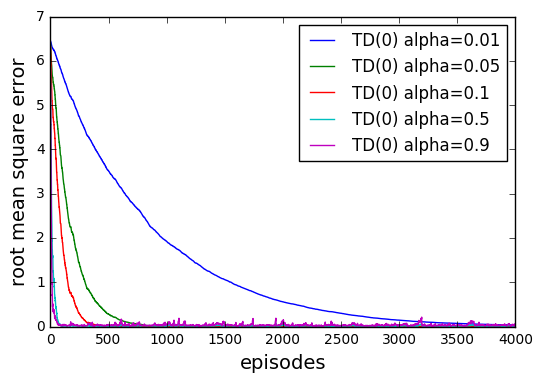

In [22]:
avg_rmse_all = np.zeros((n_episodes, len(alphas)))
for i in range(len(alphas)):
    state_value = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)
    alpha = alphas[i]
    state_value, rmse_all_runs = TD0_evaluate(n_episodes, n_runs, alpha)
    avg_rmse = np.mean(rmse_all_runs, axis=1)
    avg_rmse_all[:, i] = avg_rmse
    plt.plot(np.arange(n_episodes) + 1, avg_rmse_all[:,i], label='TD(0) alpha=' + str(alpha))    

plt.xlabel('episodes', fontsize=14)
plt.ylabel('root mean square error', fontsize=14)
plt.legend(loc='upper right')
plt.show()

**Discussion**
* It can be seen that increasing the learning rate leads to faster convergence to the actual value function.
* However, it was also observed that for very high values of the learning rate, the algorithm oscillates around the true value, never truly settling on it.
* In stationary problems, it is ideal to start the learning rate at a large value to speed up learning, but implement a schedule to decrease it over time in order to actually guarantee convergence.
* On the other hand, in non-stationary problems, keeping a constant learning rate is desired in order to ensure that the algorithm adapts quickly. Moreover, convergence is not as crucial.
